In [ ]:
!pip install ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 11.9 MB/s eta 0:00:00


In [ ]:
import ray
import random

In [ ]:
class Child_Normal(): # Standard Python class that encapsulates the data (attributes) and methods (functions) related to a "child".
    name_index = 0
    names = ['Cynthia', 'Mabel', 'Kathy', 'Taylor', 'Brenda']
    # This method is automatically called when a new instance of Child_Normal is created.
    def __init__(self):
        # Initializes each child with a randomly chosen name from a list
        self.name = Child_Normal.names[Child_Normal.name_index]
        Child_Normal.name_index = (Child_Normal.name_index + 1) % len(Child_Normal.names)
        # Initializes each child a randomly generated age between 10 and 90
        self.age = random.randint(1, 14)

    def grow(self):
        self.age += 1
        return self.age

    def greet(self):
        return (
            f'My name is {self.name} '
            f'and I am {self.age} years old'
        )

In [ ]:
child_normal_1 = Child_Normal()
child_normal_1.name # Attributes of a class are by default public, meaning they can be directly accessed and modified from outside the class.

'Cynthia'

In [ ]:
child_normal_5 = [Child_Normal() for i in range(5)]

# So that says, go through each person, randomly name and age them
# do this 5 times.
for c in child_normal_5:
    print(c.greet())

My name is Mabel and I am 14 years old
My name is Kathy and I am 14 years old
My name is Taylor and I am 12 years old
My name is Brenda and I am 10 years old
My name is Cynthia and I am 13 years old


# **The Ray Actor**
##### Actor Definition
- The actor model in computer science is a mathematical model of concurrent computation that treats an actor as the basic building block of concurrent computation.

- In response to a message it receives, an actor can: make local decisions, create more actors, send more messages, and determine how to respond to the next message received. Actors may modify their own private state, but can only affect each other indirectly through messaging (removing the need for lock-based synchronization).
- wikipedia https://en.wikipedia.org/wiki/Actor_model

#### **An actor in Ray is a Python class that is instantiated as a stateful worker in the Ray cluster**.

#### **Actors are essentially remote objects that can maintain their own state and they can have their own remote methods**.

- Actors can maintain and modify their internal state across method calls.

- When using Ray to create multiple instances of an actor, **each actor lives in its own process and does not share state with other actors by default.**

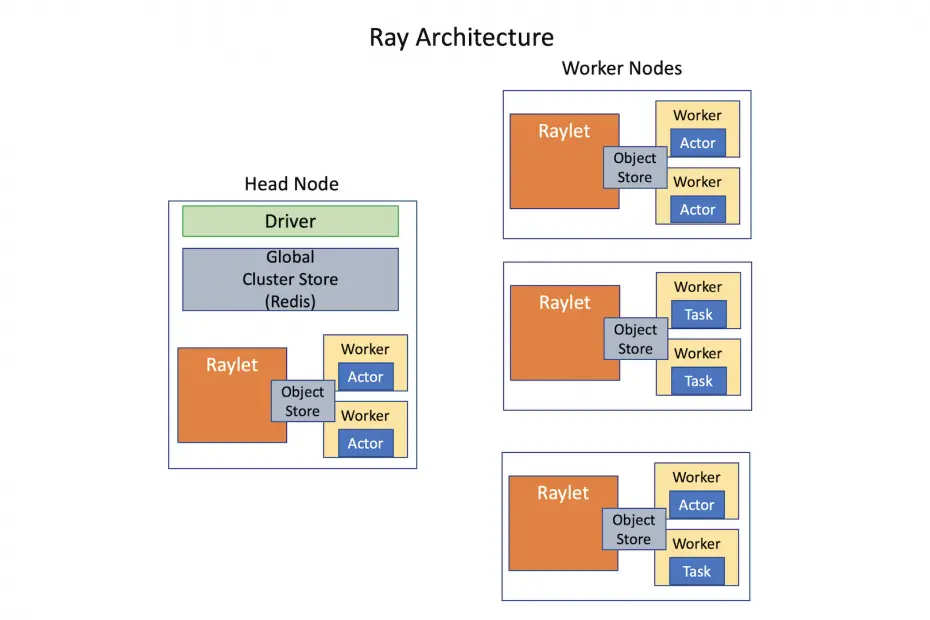    This isolation means that the name_index class variable in your Child_Ray actor class does not get shared across actor instances as you might expect when running this code in a single process (like the standard Python script above in the earlier cell).
    
     Each actor instance resets name_index to 0 when it's created, leading to the issue you're observing where every actor ends up with the same name.

     notice '**Child_Ray.remote(0)**' below instead of '**Child_Normal()**' above in the standard Python class.

To define an actor in Ray, you decorate a Python class with the @ray.remote decorator.

In [ ]:
@ray.remote # turns the Child class into an actor in the Ray framework
class Child_Ray():

    names = ['Cynthia', 'Mabel', 'Kathy', 'Taylor', 'Brenda']
    # This method is automatically called when a new instance of Child_Normal is created.
    def __init__(self, name_index):
        # Initializes each child with a randomly chosen name from a list
        self.name = Child_Ray.names[name_index % len(Child_Ray.names)]
        # Initializes each child a randomly generated age between 10 and 90
        self.age = random.randint(1, 14)

    # with Ray, communication with actors should be done through methods exposed
    # by the actor, as direct attribute access is not possible outside the actor's process.
    # get_name is the method exposed by the actor, to return the name attribute.

    # In standard Python, attributes of a class are by default public, meaning they can be
    # directly accessed and modified from outside the class, hence the normal Python class
    # above does not have a get_name method.

    # Add a method to get the name
    def get_name(self):
        return self.name

    # Add a method to get the age
    def get_age(self):
        return self.age

    def grow(self):
        self.age += 1
        return self.age

    def greet(self):
        return (
            f'My name is {self.name} '
            f'and I am {self.age} years old'
        )

You can then instantiate an actor in the Ray cluster by calling the class method .remote() on the decorated class.

In [ ]:
child_ray_1 = Child_Ray.remote(0) # initializes a Child_Ray actor
ray.get(child_ray_1.get_name.remote()) # calls methods to get the name attribute

'Cynthia'

In [ ]:
children_ray_5 = [Child_Ray.remote(i) for i in range(5)]

children_ray_5

[Actor(Child_Ray, 24fd2a9a3511ef8b94edb18d01000000),
 Actor(Child_Ray, 5213f4a96f399df41af8e1b301000000),
 Actor(Child_Ray, d4b977aec3e0546bd84b507601000000),
 Actor(Child_Ray, 33b8e9e567581674a453bcc701000000),
 Actor(Child_Ray, a1b7f128678db2da78f6a2d301000000)]

In [ ]:
# Ray get says wait for all of these methods to return and then once
# they all return, we can just go through and print out their results.

# So that says, go through each person, randomly name and age them
# do this 5 times.
for child in ray.get([c.greet.remote() for c in children_ray_5]):
  print(child)

My name is Cynthia and I am 9 years old
My name is Mabel and I am 14 years old
My name is Kathy and I am 3 years old
My name is Taylor and I am 4 years old
My name is Brenda and I am 11 years old


In [ ]:
[ray.get([c.get_name.remote(), c.grow.remote()]) for c in children_ray_5]

[['Cynthia', 10], ['Mabel', 15], ['Kathy', 4], ['Taylor', 5], ['Brenda', 12]]

In [ ]:
# Assuming children_ray_5 is already defined and populated with Child_Ray actors
child_num_1 = children_ray_5[0]  # Get the first child actor handle


# Print the name and age 5 times
for c in range(5):
  child_name = ray.get(child_num_1.get_name.remote())
  child_age = ray.get(child_num_1.grow.remote())
  print(f"Name: {child_name}, Age: {child_age}")

Name: Cynthia, Age: 11
Name: Cynthia, Age: 12
Name: Cynthia, Age: 13
Name: Cynthia, Age: 14
Name: Cynthia, Age: 15


In [ ]:
children_ray_5_growing = [Child_Ray.remote(i) for i in range(5)]


for child in ray.get([c.greet.remote() for c in children_ray_5_growing]):
  print(child)

for c in children_ray_5_growing:
    c.grow.remote()
print('\n ~~~~~~~ all children grown by 1 year ~~~~~~\n' )

for child in ray.get([c.greet.remote() for c in children_ray_5_growing]):
  print(child)

(raylet) WARNING: 130 PYTHON worker processes have been started on node: 4bcc340248edc144f5b3b454a3ae78b886feab7dc6e366c637052b1d with address: 172.28.0.12. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
My name is Cynthia and I am 12 years old
My name is Mabel and I am 12 years old
My name is Kathy and I am 11 years old
My name is Taylor and I am 9 years old
My name is Brenda and I am 4 years old

 ~~~~~~~ all children grown by 1 year ~~~~~~

My name is Cynthia and I am 13 years old
My name is Mabel and I am 13 years old
My name is Kathy and I am 12 years old
My name is Taylor and I am 10 years old
My name is Brenda and I am 5 years old


#### What is a cluster?
- a group of machines (nodes) that work together to perform distributed computing tasks.
- clusters can be deployed on various environments, including local machines, on-premises servers, and cloud platforms (AWS, Azure, GCP).

#### What is a Node?
- A single computing device. Something with processing power, memory, and storage
- Nodes can be physical or virtual machines that provide computational resources, such as CPU power, memory, and storage, to run applications, services, or tasks.
- Nodes communicate with each other over a network

#### What is a Node?
- Examples of Nodes:
*   Your laptop
*   Your desktop computer
*   Server
*   Smartphone
*   Router
*   Satellite
*   ESP32 Chip
*   Wireless Sensor, ie ESP32 Chip, Raspberry Pi, Arduino, IoT Device (e.g., Smart Thermostat)
*   Virtual Machine (VM)


#### What do Ray Nodes do?
- The head node orchestrates the distribution of tasks and management of resources across the cluster, while ...
- worker nodes execute the tasks, such as running functions or methods of Ray actors.

#### What are the two types of Ray Nodes?
- Head Node: This is the initial node of a Ray cluster. It runs the Ray scheduler, a Redis store for Ray's internal metadata, and other necessary services like the dashboard. The head node is responsible for managing the cluster's resources and tasks distribution.
- Worker Nodes: These are additional nodes that connect to the head node to form a cluster. Worker nodes provide computational resources for executing tasks and running actors. The head node schedules tasks across these worker nodes based on the available resources and the requirements of each task or actor.


## Cluster vs Node diagram example





![image.png](https://www.ge.com/digital/documentation/workflow/MultiServer_ClusterDiagram.png)

![https://www.benedat.com/wp-content/uploads/2020/12/ray-architecture-1-930x620.png](https://www.benedat.com/wp-content/uploads/2020/12/ray-architecture-1-930x620.png)

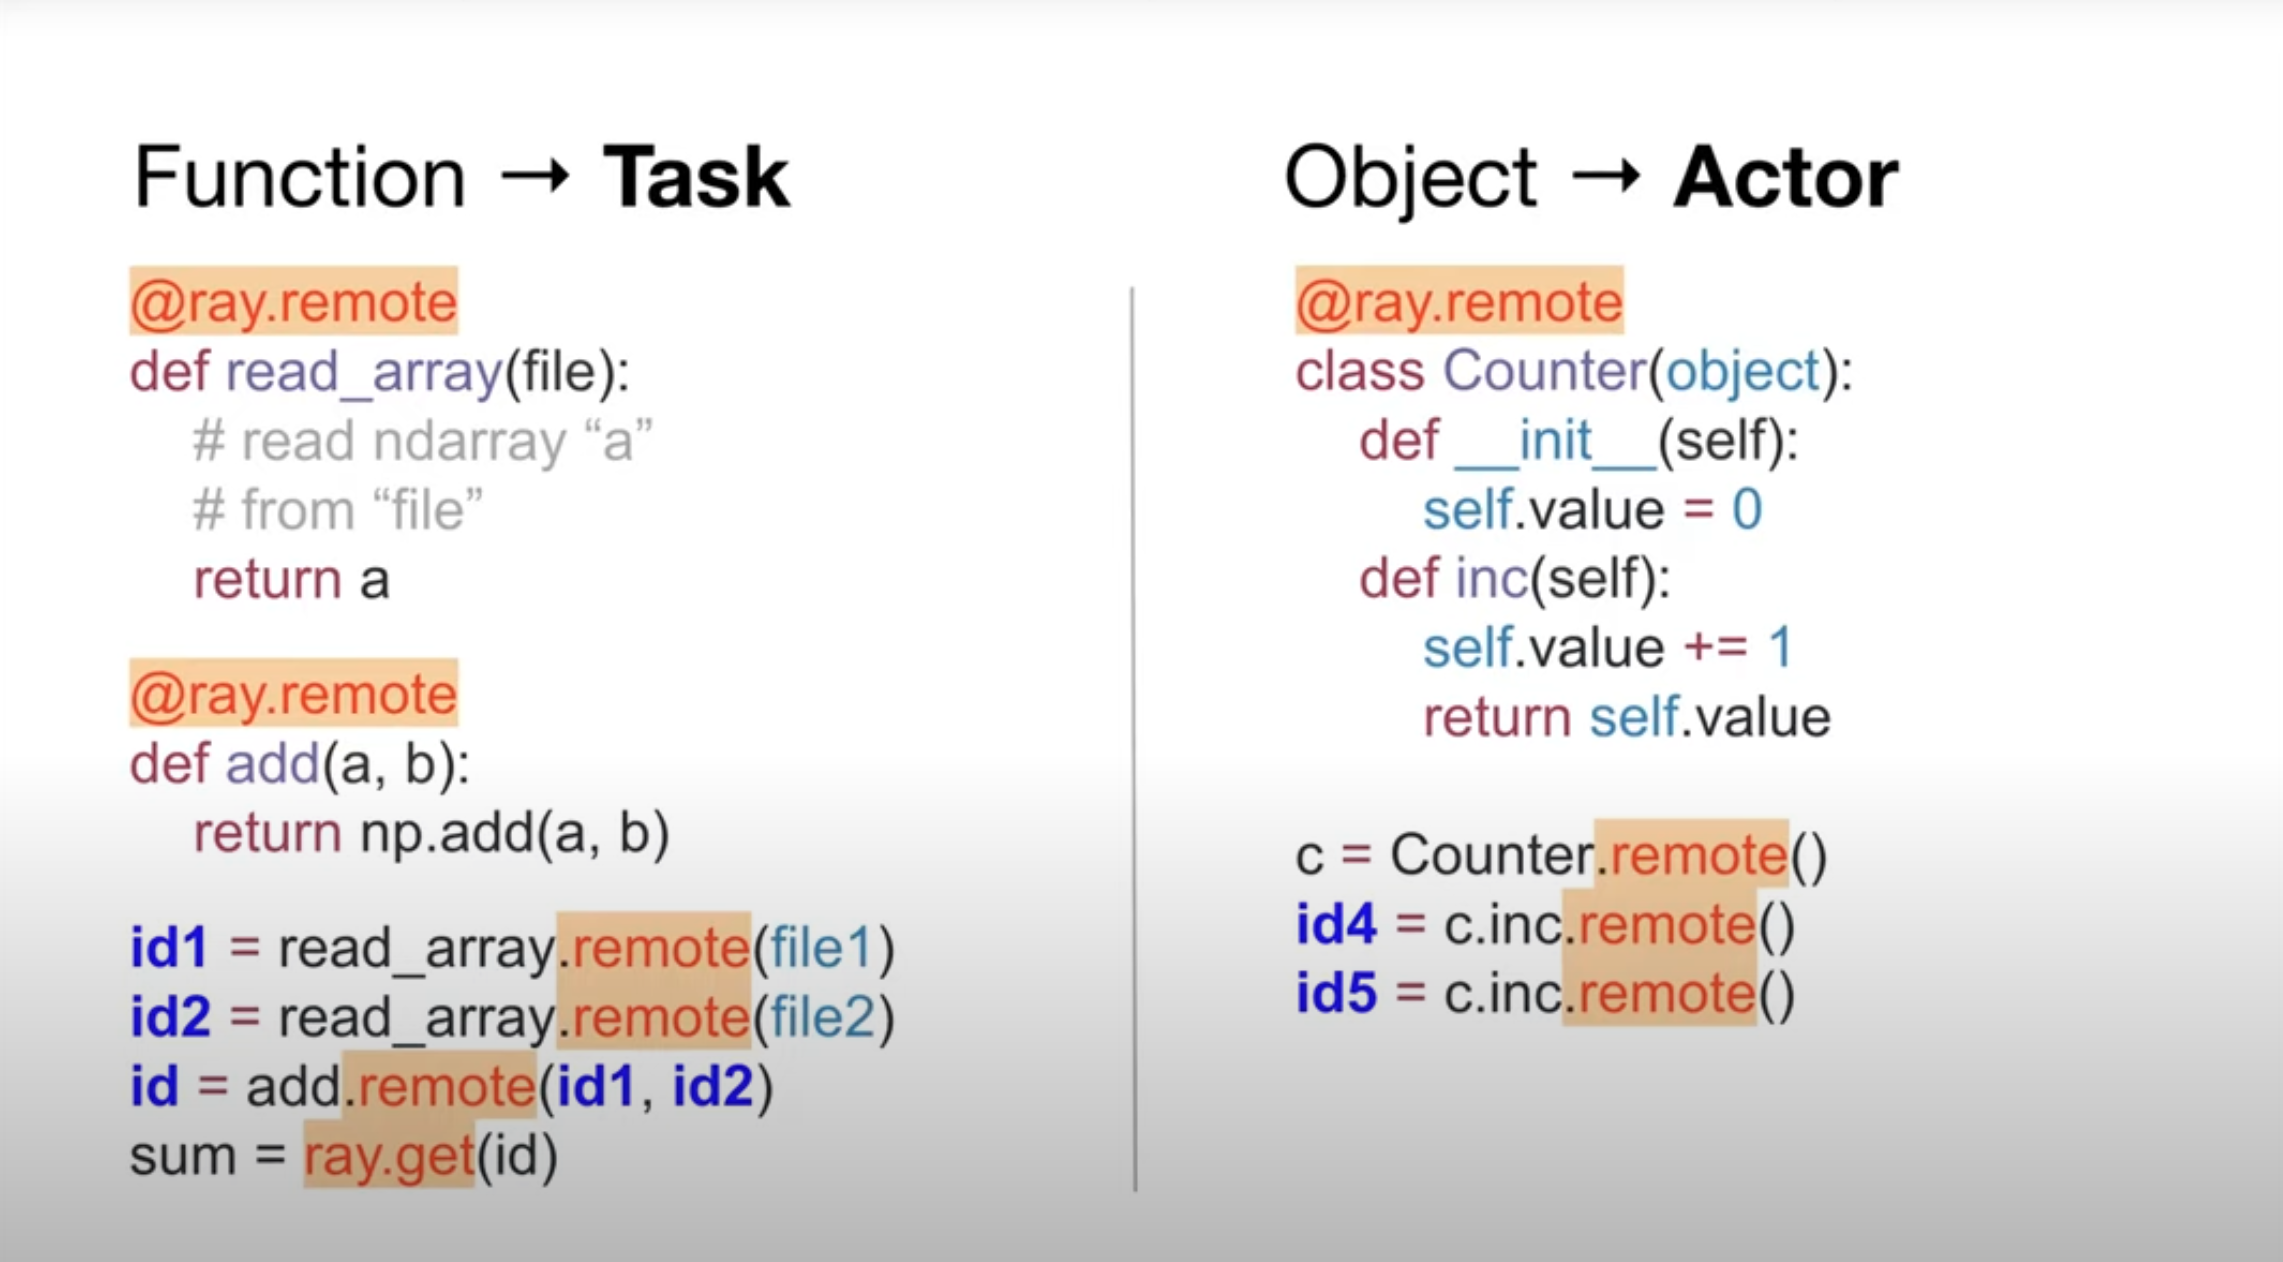


https://www.youtube.com/watch?v=iy8rFRypGq4


So you have some python functions and you have some python classes.
What happens if you want to run this python code on a cluster of hundreds of
thousands of nodes?

All you need to do is to decorate python functions and classes with a ray dot remote line of code.

This allows the function or class to become a unit of work that you can schedule to the cluster.

When calling the function or class, you use the dot remote keyword and then you can add different functions calling multiple functions together.

At the end your code with ray dot get will 'block' until you get the results.

The term 'block' means that the program waits for the completion of parallel or distributed tasks before proceeding, which is crucial for correct program execution when subsequent operations depend on the results of these tasks.

####  Tasks in Ray:
- Stateless: Tasks are stateless operations. When you define a function and execute it as a task using Ray (by calling .remote() on the function), it runs independently without maintaining any internal state between invocations.
- Asynchronous Execution: Tasks execute asynchronously and in parallel, making them suitable for computations that can be divided into independent units of work.
- No Identity: Tasks do not have a persistent identity. Each invocation of a task is considered an independent unit of work.

#### Actors in Ray:
- Stateful: Actors are stateful. They are objects instantiated from a class that can maintain state across method calls. This is useful for applications where continuity and state persistence are required.
- Concurrent Method Invocations: Actors can process method invocations concurrently. Each actor lives in its own process, allowing for parallel execution while maintaining state.
- Identity: Actors have a persistent identity. An actor instance remains the same across method calls, allowing it to retain state changes.

#### Relationship and Use Cases:
- Tasks are best suited for independent, stateless computations where parallel execution can significantly reduce execution time.
- Actors are used when there is a need for maintaining state across different operations in a distributed environment, such as in applications that require managing user sessions or maintaining game states.